<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Finance (2nd ed.)

**Mastering Data-Driven Finance**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

<img src="https://hilpisch.com/images/py4fi_2nd_shadow.png" width="300px" align="left">

# Statistics (b)

## Bayesian Regression

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

In [2]:
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(1000)
%config InlineBackend.figure_format = 'svg'

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
x = np.linspace(0, 10, 500)
y = 4 + 2 * x + np.random.standard_normal(len(x)) * 2

In [5]:
reg = np.polyfit(x, y, 1)

In [6]:
reg

array([2.03384161, 3.77649234])

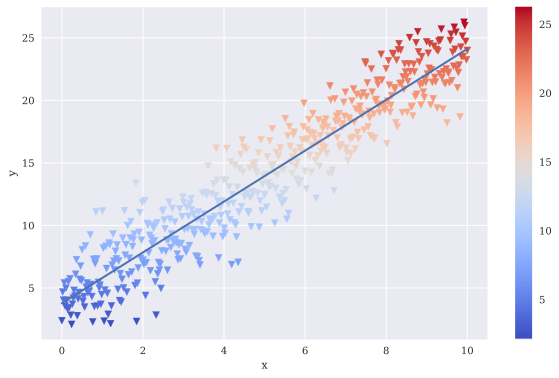

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
plt.plot(x, reg[1] + reg[0] * x, lw=2.0)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y');

<img src="https://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="https://tpq.io" target="_blank">https://tpq.io</a> | <a href="https://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>